In this file we try to train a ConvNet from scrach. 

In [1]:
%matplotlib inline

In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Lambda, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
import tensorflow as tf
from keras.callbacks import Callback, ModelCheckpoint, History, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [5]:
batch_size=16

In [7]:
train_datagen = ImageDataGenerator( 
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path+'splitted/train/',  # this is the target directory
        target_size=(512, 640),  
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        path+'splitted/validation/',
        target_size=(512, 640),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 5939 images belonging to 4 classes.
Found 1494 images belonging to 4 classes.


In [20]:
show_gen = ImageDataGenerator().flow_from_directory(path+'categorized/train/', target_size=(256, 320), class_mode='categorical', shuffle=True,
                                    batch_size=8)
show_batch, show_label = next(show_gen)

Found 5939 images belonging to 4 classes.


In [21]:
show_label

array([[ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]], dtype=float32)

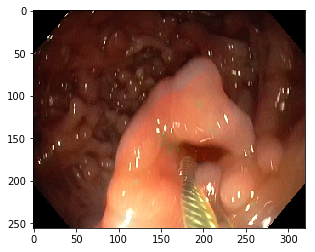

In [31]:
plt.imshow(show_batch[4].astype(np.uint8))

## Model building and training

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(512, 640, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())  
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

In [9]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [8]:
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 512, 640, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 640, 3)  0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_4 (

In [10]:
checkpointer = ModelCheckpoint(filepath=model_path+'scratch_hd0118.h5', verbose=0, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1.e-7)

earlystop = EarlyStopping(patience=30)

In [11]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples // (batch_size),
            epochs=3,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // (batch_size),
            callbacks = [checkpointer, reduce_lr, earlystop],
            verbose=1);

Epoch 1/3
371/371 [==============================] - 2594s 7s/step - loss: 0.8548 - acc: 0.7314 - val_loss: 0.7539 - val_acc: 0.7487
Epoch 2/3
253/371 [===================>..........] - ETA: 12:47 - loss: 0.7830 - acc: 0.7339

KeyboardInterrupt: 

In [18]:
history.history

{'acc': [0.72896563401374792, 0.7348908076073204, 0.73522938883040223],
 'loss': [4.2890150838845145, 4.2730552807906887, 4.2675980012066095],
 'lr': [0.001, 0.001, 0.001],
 'val_acc': [0.75679347826086951, 0.75679347826086951, 0.75679347826086951],
 'val_loss': [3.9200260069059394, 3.9200260069059394, 3.9200260069059394]}

In [26]:
with open('history_hd.pkl', 'wb') as f:
    pickle.dump(history.history, f, -1)

In [28]:
with open('history_hd.pkl', 'rb') as f:
    hist = pickle.load(f)

In [29]:
hist

{'acc': [0.72896563401374792, 0.7348908076073204, 0.73522938883040223],
 'loss': [4.2890150838845145, 4.2730552807906887, 4.2675980012066095],
 'lr': [0.001, 0.001, 0.001],
 'val_acc': [0.75679347826086951, 0.75679347826086951, 0.75679347826086951],
 'val_loss': [3.9200260069059394, 3.9200260069059394, 3.9200260069059394]}

## Result evaluation

In [7]:
loss_history = np.load('loss0116.npy')

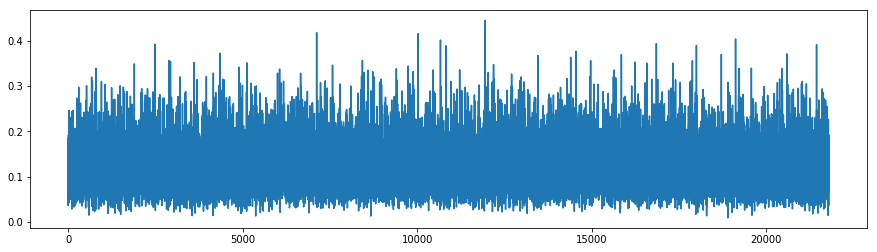

In [52]:
plt.figure(figsize=(15, 4))
plt.plot(loss_history[15000:])

In [33]:
parallel_model.load_weights(model_path+'scratch0116.h5')

In [34]:
y_pred = parallel_model.predict_generator(validation_generator)
y_pred_class = y_pred.argmax(axis=1)

In [35]:
sum(y_pred_class == 0), sum(y_pred_class == 1),sum(y_pred_class == 2), sum(y_pred_class == 3)

(1134, 198, 124, 38)

In [36]:
class_gen = test_datagen.flow_from_directory(
        path+'splitted/validation/',
        target_size=(4, 5),
        batch_size=1494,
        shuffle=False,
        class_mode='categorical')
X_waste, y_true = next(class_gen)

Found 1494 images belonging to 4 classes.


In [38]:
y_true_class = y_true.argmax(axis=1)

In [44]:
np.save('y_true_class.npy', y_true_class)

In [46]:
y_true_class.shape

(1494,)

In [74]:
y_pred_class[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [51]:
df = pd.DataFrame(data=np.column_stack((y_true_class, y_pred_class)), columns=('true', 'pred'))

In [59]:
pd.crosstab(index=df.true, columns=df.pred, margins=True)

pred,0,1,2,3,All
true,,,,,
0,1079,28,6,1,1114
1,46,161,9,0,216
2,5,7,102,3,117
3,4,2,7,34,47
All,1134,198,124,38,1494


In [58]:
pd.crosstab(index=df.true, columns=df.pred).apply(lambda r: r/r.sum(), axis=1)

pred,0,1,2,3
true,,,,
0,0.968582,0.025135,0.005386,0.000898
1,0.212963,0.745370,0.041667,0.000000
2,0.042735,0.059829,0.871795,0.025641
3,0.085106,0.042553,0.148936,0.723404
